In [58]:
import numpy as np
import pandas as pd
import datetime
from IPython.display import display
import statsmodels.stats.proportion as smp
import matplotlib.pyplot as plt
import seaborn as sns;

%matplotlib inline

pd.options.display.max_columns = None

# 1. Data collection, cleaning, and exploratory data analysis

## a. load email list 

In [5]:
PO_number_list = ['ml_funding_enables_investing','ml_investing_starts_here','ml_explore_the_app_investing',
                  'ml_funding_faq','ml_user_clustering_emails_fracs','ml_funding_is_safe','ml_picking_an_investment', 
                  'ml_investing_101','ml_diversified_portfolio','ml_explore_the_app_list']

## b. load user segment information

In [9]:
segment_group_init_df = pd.read_csv("/Users/david/Code_Files/projects/project3/project1/data/sample_segment_groups.csv")
segment_group_init_df = segment_group_init_df.drop(columns='Unnamed: 0')
segment_group_init_df.head()

,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag,user_uuid,group_name
0,0,False,False,False,False,4418550,ML_unfund_exp_control
1,1,False,False,True,False,314921,20D_Act
2,2,False,False,True,True,409786,20D_Act-5D_Act
3,3,False,True,False,False,941341,link
4,4,False,True,True,False,102541,link-20D_Act


1. approved_within6M_flag: whether the email is approved within 6 months
2. link_flag: wether it is linked to bank
3. recent_activity_flag(20days): whether there are activities within the last 20 days
4. 5day_trade_flag: whether there are trading activities in the past 5 days
5. group_id: id for each group, 0-11
6. user_uuid: it is the count of user uuids, not uuid number itself

In general, this dataframe contains user segmentation rules and counts for users in each segment, labeled as 'group_id' 

## c. Load sampled users with Email delivery orders for the experiment

In [10]:
sample_exp_df = pd.read_csv("/Users/david/Code_Files/projects/project3/project1/data/sample_uuid_email_order.csv")
sample_exp_df.head()

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,0,ML_unfund_exp_control_D,5,7,3,4,8,9,0,1,6,2
1,id_14752263936159847779,0,ML_unfund_exp_control_D,3,1,6,0,5,9,4,8,7,2
2,id_3723259155072282145,0,ML_unfund_exp_control_D,8,7,3,6,1,4,2,9,0,5
3,id_9433964625840258739,0,ML_unfund_exp_control_D,1,8,0,6,5,7,4,9,3,2
4,id_17251718038176858460,0,ML_unfund_exp_control_D,6,1,8,0,7,3,5,2,9,4


In [11]:
sample_exp_df.shape

(480000, 13)

1. useru_uuid is the unique user id for each user
2. group_id is the group id, 0-23
3. group_name has two kinds of surflix, '_D' means emails delivered to users once a day, '_W' means delivered twice a week 
4. order_ columns hold the index of emails to be delivered to users. For '_D', order_n means day n; and for '_W', order_n stands for nth deliver in that week. The index of the email represents the email to be sent on that day from the list 'PO_number_list'

## d. load email events

In [12]:
email_event_summary_df = pd.read_csv("/Users/david/Code_Files/projects/project3/project1/data/email_events.csv")
email_event_summary_df.head()

,stitch_email_events.category,stitch_email_events.dt_date,user_uuid,event,reason,stitch_email_events.count_events
0,"[""ml_picking_an_investment"",""post-office""]",2020-12-30,id_13999943483500367320,open,NaN,1
1,"[""ml_explore_the_app_investing"",""post-office""]",2020-12-30,id_3965698071238241409,open,NaN,1
2,"[""ml_picking_an_investment"",""post-office""]",2020-12-30,id_9648414115970654735,open,NaN,1
3,"[""ml_investing_starts_here"",""post-office""]",2020-12-30,id_8951454012305223869,open,NaN,1
4,"[""ml_investing_101"",""post-office""]",2020-12-30,id_8180145303883056882,open,NaN,2


In [13]:
email_event_summary_df['event'].unique()

array(['open', 'unsubscribe', 'spamreport', 'deferred', 'bounce',
       'processed', 'delivered', 'dropped'], dtype=object)

## e. load email user status 

In [15]:
user_event_df = pd.read_csv("/Users/david/Code_Files/projects/project3/project1/data/user_events.csv")
user_event_df.head()

,user_uuid,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,approved_at,first_funded_at,first_linked_bank_account_at,5d_trading_avg_event_count,2d_non_trading_avg_event_count,20d_trading_avg_event_count,8d_non_trading_avg_event_count,1d_trading_avg_event_count,1d_non_trading_avg_event_count,num_received_email
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-14 16:31:59.295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered,2019-01-29 16:22:26.866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,open,open,delivered,delivered,delivered,delivered,open,2019-02-01 00:01:48.853,2020-12-04 20:41:55.146,2020-12-04 20:41:37.842,53.0,NaN,171.0,NaN,NaN,NaN,6
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,2020-03-17 21:02:43.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30 18:23:15.726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


current account status of users
1. ml_ columns shows the interaction between users and email, can be open, delivered, etc
2. approved_at: date account is approved
3. first_funded_at: date account fired funded
4. nd_(non)_trading_avg_event_count: count of average (none) trading in last n days 

# 2. Feature engineering: calculate metrics

## a. Define metrics: email open rate

percentage of treatment group who opened the email after received

In [20]:
total_delivered_df = user_event_df[['user_uuid', 'group_name'] + PO_number_list]
for i in PO_number_list:
    total_delivered_df[i] = total_delivered_df[i].notnull()
    
total_delivered_df = total_delivered_df.groupby('group_name').sum().reset_index()
total_delivered_df.head()

/var/folders/_h/y97f273d48b9yk9g59hq9hcc0000gn/T/ipykernel_1679/1534559558.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_delivered_df[i] = total_delivered_df[i].notnull()
/var/folders/_h/y97f273d48b9yk9g59hq9hcc0000gn/T/ipykernel_1679/1534559558.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_delivered_df = total_delivered_df.groupby('group_name').sum().reset_index()


,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,19230,19257,19252,19251,19253,19251,19271,19265,19241,19249
1,20D_Act-5D_Act_W,17412,17292,17346,17323,17299,17365,17319,17294,17347,17294
2,20D_Act_D,19062,19040,19054,19055,19060,19050,19056,19050,19052,19042
3,20D_Act_W,17202,17132,17148,17107,17052,17156,17108,17097,17156,17094
4,6M_App-20D_Act-5D_Act_D,19290,19285,19268,19289,19283,19285,19270,19282,19308,19273


In [29]:
total_opened_df = user_event_df[['user_uuid','group_name'] + PO_number_list]
for i in PO_number_list:
    total_opened_df[i] = total_opened_df[i] == 'open'
    
total_opened_df = total_opened_df.groupby('group_name').sum().reset_index()
total_opened_df.head()

/var/folders/_h/y97f273d48b9yk9g59hq9hcc0000gn/T/ipykernel_1679/2389593349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_opened_df[i] = total_opened_df[i] == 'open'
/var/folders/_h/y97f273d48b9yk9g59hq9hcc0000gn/T/ipykernel_1679/2389593349.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_opened_df = total_opened_df.groupby('group_name').sum().reset_index()


,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,3191,3140,3171,5054,3407,3215,3306,3243,3043,3290
1,20D_Act-5D_Act_W,2873,2875,2843,4545,3117,2878,2924,2869,2829,2879
2,20D_Act_D,3464,3455,3487,5108,3650,3501,3545,3476,3524,3520
3,20D_Act_W,3022,3094,3058,4598,3146,3134,3084,3113,3010,3170
4,6M_App-20D_Act-5D_Act_D,3465,3493,3423,4896,3698,3486,3644,3520,3430,3590


In [36]:
open_rate_df = total_opened_df.copy()
for i in PO_number_list:
    open_rate_df[i] = total_opened_df[i] / (total_delivered_df[i] + 1e-10)
open_rate_df.head()

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,0.165939,0.163058,0.164710,0.262532,0.176959,0.167004,0.171553,0.168336,0.158152,0.170918
1,20D_Act-5D_Act_W,0.165001,0.166262,0.163899,0.262368,0.180184,0.165736,0.168832,0.165896,0.163083,0.166474
2,20D_Act_D,0.181723,0.181460,0.183006,0.268066,0.191501,0.183780,0.186031,0.182467,0.184967,0.184855
3,20D_Act_W,0.175677,0.180598,0.178330,0.268779,0.184494,0.182677,0.180267,0.182079,0.175449,0.185445
4,6M_App-20D_Act-5D_Act_D,0.179627,0.181125,0.177652,0.253823,0.191775,0.180762,0.189102,0.182554,0.177647,0.186271


## b. create heat map

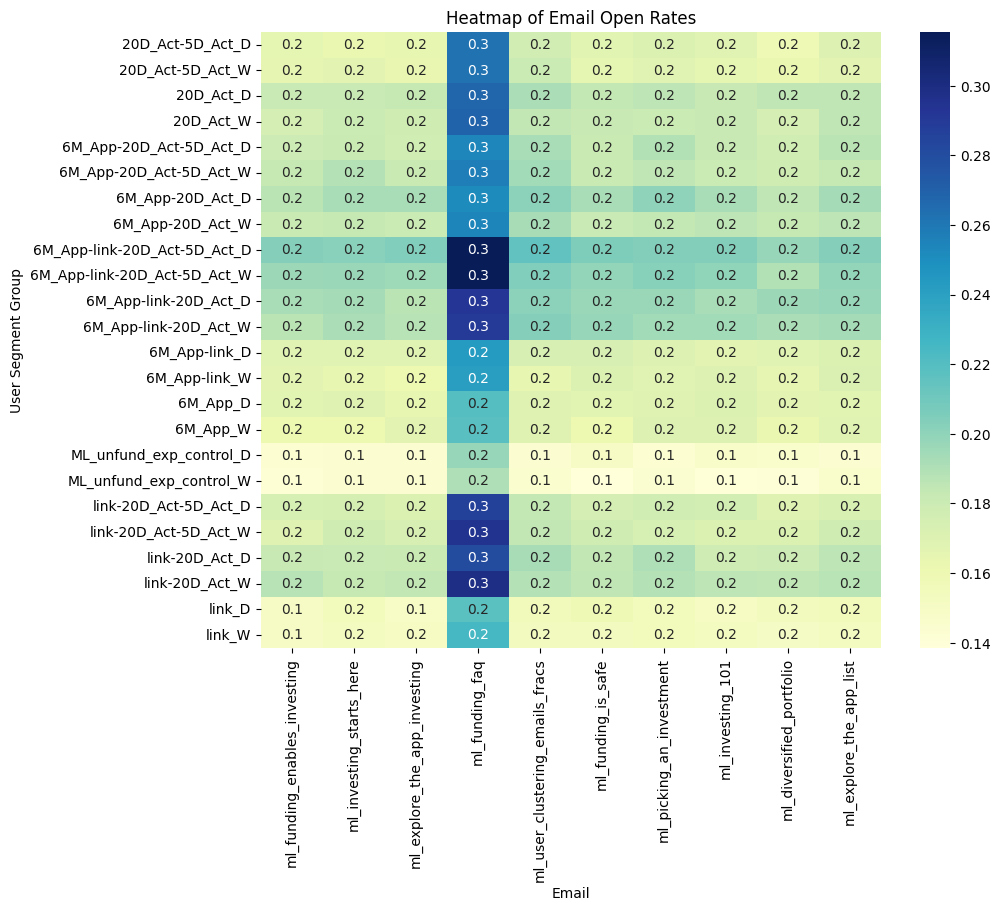

In [31]:
open_rate_df.set_index('group_name', inplace=True)

heatmap_data = open_rate_df[PO_number_list]

plt.figure(figsize=(10, 8))

sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")

plt.title('Heatmap of Email Open Rates')
plt.xlabel('Email')
plt.ylabel('User Segment Group')
plt.show()

As we can see from the heat map, 'ml_funding_faq' is has the highest open rate, and '6M_App-link-20D_Act-5D_Act_D', '6M_App-link-20D_Act-5D_Act_W' are the most efficient user segment. 

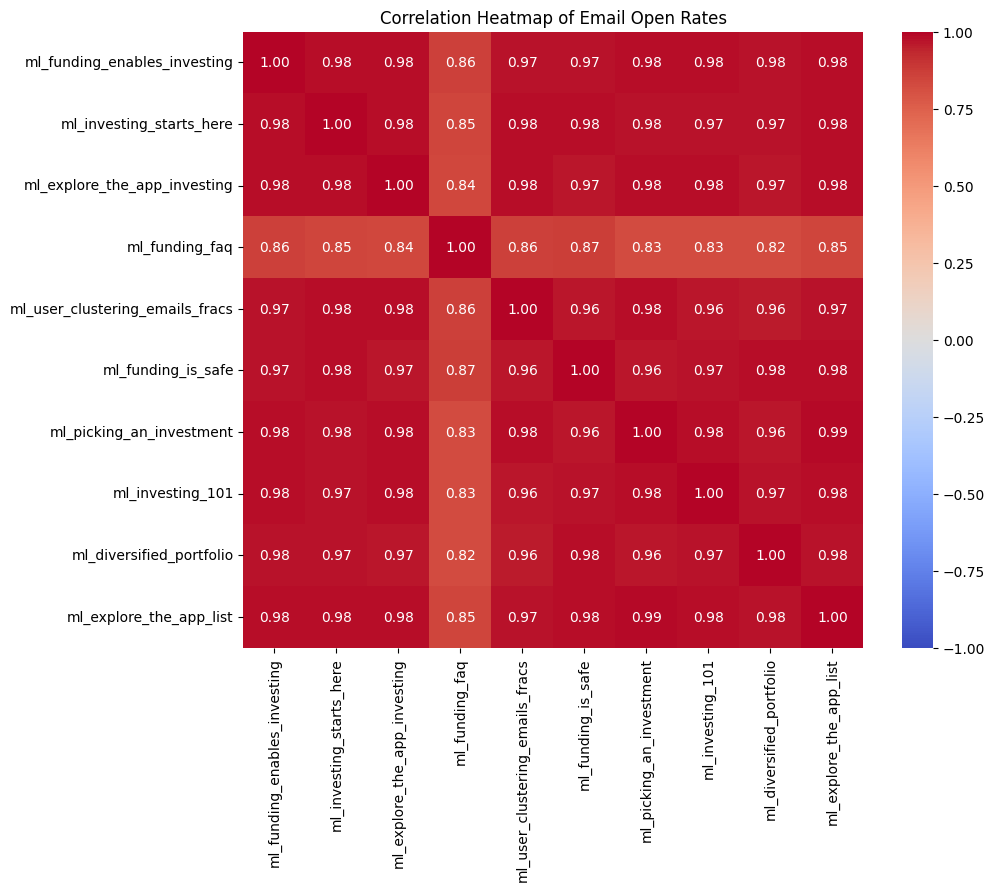

In [32]:
# Calculate the correlation matrix
corr = open_rate_df[PO_number_list].corr()

plt.figure(figsize=(10, 8))

# Generate a heatmap from the correlation matrix
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1)

plt.title('Correlation Heatmap of Email Open Rates')
plt.show()

# 3. A/B testing

## a. load control group 

In [17]:
control_group_df = pd.read_csv("/Users/david/Code_Files/projects/project3/project1/data/control_groups_rate.csv")
control_group_df.head()

,group_name,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control
0,20D_Act-5D_Act_D,369786,7802,0.021099,9899,0.026770
1,20D_Act_D,274921,4053,0.014742,5143,0.018707
2,6M_App-20D_Act-5D_Act_D,193445,11556,0.059738,13396,0.069250
3,6M_App-20D_Act_D,178938,5636,0.031497,6570,0.036717
4,6M_App-link-20D_Act-5D_Act_D,29697,3047,0.102603,29697,1.000000


# b. open rate correlation analysis 

In [43]:
# Create a copy of the open rate table 
open_rate_flat_df = open_rate_df.copy()
open_rate_flat_df.head()

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,0.165939,0.163058,0.164710,0.262532,0.176959,0.167004,0.171553,0.168336,0.158152,0.170918
1,20D_Act-5D_Act_W,0.165001,0.166262,0.163899,0.262368,0.180184,0.165736,0.168832,0.165896,0.163083,0.166474
2,20D_Act_D,0.181723,0.181460,0.183006,0.268066,0.191501,0.183780,0.186031,0.182467,0.184967,0.184855
3,20D_Act_W,0.175677,0.180598,0.178330,0.268779,0.184494,0.182677,0.180267,0.182079,0.175449,0.185445
4,6M_App-20D_Act-5D_Act_D,0.179627,0.181125,0.177652,0.253823,0.191775,0.180762,0.189102,0.182554,0.177647,0.186271


In [45]:
# Create new columns 'daily' and 'twice_a_week' based on the presence of '_D' and '_W' in 'group_name'. 
open_rate_flat_df['daily'] = open_rate_flat_df['group_name'].str.contains('_D')
open_rate_flat_df['twice_a_week'] = open_rate_flat_df['group_name'].str.contains('_W')

# Strip '_D' and '_W' from 'group_name':
open_rate_flat_df['group_name'] = open_rate_flat_df['group_name'].replace({'_D$': '', '_W$': ''}, regex=True)

# Merge open_rate_flat_df with segment_group_init_df on 'group_name':
open_rate_flat_df = open_rate_flat_df.merge(segment_group_init_df, how='left', on='group_name')
open_rate_flat_df.head()

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,daily,twice_a_week,group_id_x,approved_within6M_flag_x,link_flag_x,recent_activity_flag(20days)_x,5day_trade_flag_x,user_uuid_x,group_id_y,approved_within6M_flag_y,link_flag_y,recent_activity_flag(20days)_y,5day_trade_flag_y,user_uuid_y
0,20D_Act-5D_Act,0.165939,0.163058,0.164710,0.262532,0.176959,0.167004,0.171553,0.168336,0.158152,0.170918,False,False,2,False,False,True,True,409786,2,False,False,True,True,409786
1,20D_Act-5D_Act,0.165001,0.166262,0.163899,0.262368,0.180184,0.165736,0.168832,0.165896,0.163083,0.166474,False,False,2,False,False,True,True,409786,2,False,False,True,True,409786
2,20D_Act,0.181723,0.181460,0.183006,0.268066,0.191501,0.183780,0.186031,0.182467,0.184967,0.184855,False,False,1,False,False,True,False,314921,1,False,False,True,False,314921
3,20D_Act,0.175677,0.180598,0.178330,0.268779,0.184494,0.182677,0.180267,0.182079,0.175449,0.185445,False,False,1,False,False,True,False,314921,1,False,False,True,False,314921
4,6M_App-20D_Act-5D_Act,0.179627,0.181125,0.177652,0.253823,0.191775,0.180762,0.189102,0.182554,0.177647,0.186271,False,False,8,True,False,True,True,233445,8,True,False,True,True,233445


In [48]:
open_rate_flat_template_df = open_rate_flat_df.copy()
open_rate_flat_template_df[PO_number_list] = False

open_rate_flat_TF_df = pd.DataFrame()
for e in PO_number_list:
    temp = open_rate_flat_template_df.copy()
    temp[e] = True
    temp['open_rate'] = open_rate_flat_df[e]
    open_rate_flat_TF_df = pd.concat([open_rate_flat_TF_df, temp])

open_rate_flat_TF_df = open_rate_flat_TF_df.reset_index()
open_rate_flat_TF_df = open_rate_flat_TF_df.drop(columns = ['index'])
open_rate_flat_TF_df.head()

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,daily,twice_a_week,group_id_x,approved_within6M_flag_x,link_flag_x,recent_activity_flag(20days)_x,5day_trade_flag_x,user_uuid_x,group_id_y,approved_within6M_flag_y,link_flag_y,recent_activity_flag(20days)_y,5day_trade_flag_y,user_uuid_y,open_rate
0,20D_Act-5D_Act,True,False,False,False,False,False,False,False,False,False,False,False,2,False,False,True,True,409786,2,False,False,True,True,409786,0.165939
1,20D_Act-5D_Act,True,False,False,False,False,False,False,False,False,False,False,False,2,False,False,True,True,409786,2,False,False,True,True,409786,0.165001
2,20D_Act,True,False,False,False,False,False,False,False,False,False,False,False,1,False,False,True,False,314921,1,False,False,True,False,314921,0.181723
3,20D_Act,True,False,False,False,False,False,False,False,False,False,False,False,1,False,False,True,False,314921,1,False,False,True,False,314921,0.175677
4,6M_App-20D_Act-5D_Act,True,False,False,False,False,False,False,False,False,False,False,False,8,True,False,True,True,233445,8,True,False,True,True,233445,0.179627


In [50]:
# Perform the correlation analysis on open rate
corr = open_rate_flat_TF_df.corr()

corr = corr.sort_values(by=['open_rate'], ascending=False)
corr['open_rate']

/var/folders/_h/y97f273d48b9yk9g59hq9hcc0000gn/T/ipykernel_1679/2670322122.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = open_rate_flat_TF_df.corr()


open_rate                          1.000000
ml_funding_faq                     0.793531
recent_activity_flag(20days)_y     0.450146
recent_activity_flag(20days)_x     0.450146
group_id_x                         0.364588
group_id_y                         0.364588
approved_within6M_flag_y           0.241516
approved_within6M_flag_x           0.241516
5day_trade_flag_x                  0.172443
5day_trade_flag_y                  0.172443
link_flag_x                        0.160358
link_flag_y                        0.160358
ml_user_clustering_emails_fracs   -0.025562
ml_picking_an_investment          -0.065907
ml_explore_the_app_list           -0.074458
ml_funding_is_safe                -0.082867
ml_investing_101                  -0.090776
ml_investing_starts_here          -0.098976
ml_funding_enables_investing      -0.114963
ml_explore_the_app_investing      -0.117040
ml_diversified_portfolio          -0.122984
user_uuid_x                       -0.413757
user_uuid_y                     

## c.  funding rate, link rate, and activity rate calculations 

In [46]:
# Group user_event_df data by 'group_name' and count the number of 'user_uuid' for those who have received more than 0 emails:
fund_exp_df = user_event_df[user_event_df['num_received_email']>0].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df = fund_exp_df.rename(columns = {'user_uuid':'num_users_received_email'})
fund_exp_df.head()

,group_name,num_users_received_email
0,20D_Act-5D_Act_D,18918
1,20D_Act-5D_Act_W,18966
2,20D_Act_D,18606
3,20D_Act_W,18711
4,6M_App-20D_Act-5D_Act_D,18927


In [51]:
fund_exp_df = user_event_df[user_event_df['num_received_email']>0].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df = fund_exp_df.rename(columns = {'user_uuid':'num_users_received_email'})

# funding rate 
temp = user_event_df[user_event_df['first_funded_at'].notnull()].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df['num_funded'] = temp['user_uuid']
fund_exp_df['funding_rate'] = fund_exp_df['num_funded'] /fund_exp_df['num_users_received_email'] 

# link rate
temp = user_event_df[user_event_df['first_linked_bank_account_at'].notnull()].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df['num_link'] = temp['user_uuid']
fund_exp_df['link_rate'] = fund_exp_df['num_link'] /fund_exp_df['num_users_received_email'] 
fund_exp_df.loc[fund_exp_df['link_rate']>1,'link_rate'] = 1

# activity rate
act_list = []
for a in user_event_df.columns:
    if '_event_count' in a:
        act_list.append(a)
        
temp = user_event_df[user_event_df[act_list].sum(axis=1)>0].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df['num_act'] = temp['user_uuid']
fund_exp_df['act_rate'] = fund_exp_df['num_act'] /fund_exp_df['num_users_received_email'] 
fund_exp_df.loc[fund_exp_df['act_rate']>1,'act_rate'] = 1

fund_exp_df.head()

,group_name,num_users_received_email,num_funded,funding_rate,num_link,link_rate,num_act,act_rate
0,20D_Act-5D_Act_D,18918,451,0.023840,586,0.030976,20000,1.000000
1,20D_Act-5D_Act_W,18966,450,0.023727,555,0.029263,20000,1.000000
2,20D_Act_D,18606,357,0.019187,460,0.024723,11135,0.598463
3,20D_Act_W,18711,310,0.016568,395,0.021111,11091,0.592753
4,6M_App-20D_Act-5D_Act_D,18927,1259,0.066519,1465,0.077403,20000,1.000000


In [54]:
# Calculate the overall funding rate
total_users_received_email = fund_exp_df['num_users_received_email'].sum()
if total_users_received_email != 0:
    print(fund_exp_df['num_funded'].sum() / total_users_received_email)
else:
    print("No users received email.")
    
# Here, we're checking for divide-by-zero scenarios. If no users received an email, it would not be appropriate to calculate the funding rate.

0.03442991255931208


In [67]:
# Merge the tables together
# I used 'ffill' as the method for filling in the missing values. 
# This method fills missing values by carrying forward the previous value. 
# However, it should be noted that with this approach, if the missing values are not missing at random, 
# this could introduce bias into the overall analysis.
exp_funding_merge_df = fund_exp_df.merge(control_group_df,how = 'left', on = 'group_name')
exp_funding_merge_df = exp_funding_merge_df.fillna(method='ffill')
exp_funding_merge_df.head()

,group_name,num_users_received_email,num_funded,funding_rate,num_link,link_rate,num_act,act_rate,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control
0,20D_Act-5D_Act_D,18918,451,0.023840,586,0.030976,20000,1.000000,369786.0,7802.0,0.021099,9899.0,0.026770
1,20D_Act-5D_Act_W,18966,450,0.023727,555,0.029263,20000,1.000000,369786.0,7802.0,0.021099,9899.0,0.026770
2,20D_Act_D,18606,357,0.019187,460,0.024723,11135,0.598463,274921.0,4053.0,0.014742,5143.0,0.018707
3,20D_Act_W,18711,310,0.016568,395,0.021111,11091,0.592753,274921.0,4053.0,0.014742,5143.0,0.018707
4,6M_App-20D_Act-5D_Act_D,18927,1259,0.066519,1465,0.077403,20000,1.000000,193445.0,11556.0,0.059738,13396.0,0.069250


## d. A/B testing

Now we can calculate the difference in funding and link rates between the treatment and control groups, and conduct statistical tests to see if the differences are significant.

We'll use a two-sample Z-test for proportions, as it's suitable for comparing proportions from two independent groups. 

In [71]:
# Calculate differences between treatment and control for funding rate and link rate
exp_funding_merge_df['delta_fund_rate'] = exp_funding_merge_df['funding_rate'] - exp_funding_merge_df['funding_rate_in_control']
exp_funding_merge_df['delta_link_rate'] = exp_funding_merge_df['link_rate'] - exp_funding_merge_df['link_rate_in_control']
exp_funding_merge_df.head()

,group_name,num_users_received_email,num_funded,funding_rate,num_link,link_rate,num_act,act_rate,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control,delta_fund_rate,delta_link_rate
0,20D_Act-5D_Act_D,18918,451,0.023840,586,0.030976,20000,1.000000,369786.0,7802.0,0.021099,9899.0,0.026770,0.002741,0.004206
1,20D_Act-5D_Act_W,18966,450,0.023727,555,0.029263,20000,1.000000,369786.0,7802.0,0.021099,9899.0,0.026770,0.002628,0.002493
2,20D_Act_D,18606,357,0.019187,460,0.024723,11135,0.598463,274921.0,4053.0,0.014742,5143.0,0.018707,0.004445,0.006016
3,20D_Act_W,18711,310,0.016568,395,0.021111,11091,0.592753,274921.0,4053.0,0.014742,5143.0,0.018707,0.001825,0.002403
4,6M_App-20D_Act-5D_Act_D,18927,1259,0.066519,1465,0.077403,20000,1.000000,193445.0,11556.0,0.059738,13396.0,0.069250,0.006781,0.008153


In [80]:
funding_p_values = []
linking_p_values = []
funding_z_scores = []
linking_z_scores = []
group_names = []

# iterate over each row in the dataframe and append its p-values and z-values to its array
for index, row in exp_funding_merge_df.iterrows():
    group_names.append(row['group_name'])
    # collect data for funding rate
    count = np.array([row['num_funded'], row['num_funded_in_control']])
    nobs = np.array([row['num_users_received_email'], row['num_users_in_control']])
    
    # perform z-test for funding rate
    z, p = smp.proportions_ztest(count, nobs)
    funding_z_scores.append(z)
    funding_p_values.append(p)
    print(f"Funding Rate: z-score = {z:.2f}, p-value = {p:.4f}")
    
    # collect data for link rate
    count = np.array([row['num_link'], row['num_link_in_control']])
    
    # perform z-test for link rate
    z, p = smp.proportions_ztest(count, nobs)
    linking_z_scores.append(z)
    linking_p_values.append(p)
    print(f"Link Rate: z-score = {z:.2f}, p-value = {p:.4f}")

Funding Rate: z-score = 2.55, p-value = 0.0107
Link Rate: z-score = 3.48, p-value = 0.0005
Funding Rate: z-score = 2.45, p-value = 0.0143
Link Rate: z-score = 2.07, p-value = 0.0384
Funding Rate: z-score = 4.82, p-value = 0.0000
Link Rate: z-score = 5.80, p-value = 0.0000
Funding Rate: z-score = 2.00, p-value = 0.0458
Link Rate: z-score = 2.34, p-value = 0.0194
Funding Rate: z-score = 3.74, p-value = 0.0002
Link Rate: z-score = 4.20, p-value = 0.0000
Funding Rate: z-score = 3.28, p-value = 0.0010
Link Rate: z-score = 3.62, p-value = 0.0003
Funding Rate: z-score = 4.07, p-value = 0.0000
Link Rate: z-score = 3.95, p-value = 0.0001
Funding Rate: z-score = 2.11, p-value = 0.0345
Link Rate: z-score = 2.59, p-value = 0.0095
Funding Rate: z-score = 3.95, p-value = 0.0001
Link Rate: z-score = nan, p-value = nan
Funding Rate: z-score = 3.25, p-value = 0.0012
Link Rate: z-score = nan, p-value = nan
Funding Rate: z-score = 2.60, p-value = 0.0094
Link Rate: z-score = nan, p-value = nan
Funding Rat

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/proportion.py:1025: RuntimeWarning: invalid value encountered in sqrt
  std_diff = np.sqrt(var_)


As we can see in the result, many of the p-values are less than the common threshold of 0.05, suggesting there are statistically significant differences between the treatment and control groups for both funding rate and link rate.

However, there are also some p-values that are 'nan', which suggests that the Z-test couldn't be performed due to certain conditions not being met. For example, it could be that the counts of the 'num_link' or 'num_users_received_email' variables are zero, which would lead to an undefined z-score and p-value.

Now let's put the p-values into a DataFrame for easier manipulation, and then plot them out to have a better visualization.

In [83]:
df_p_values = pd.DataFrame({
    'group_name': group_names,
    'funding_p_value': funding_p_values,
    'linking_p_value': linking_p_values,
    'funding_z_score': funding_z_scores,
    'linking_z_score': linking_z_scores
})
df_p_values.head()

,group_name,funding_p_value,linking_p_value,funding_z_score,linking_z_score
0,20D_Act-5D_Act_D,0.010747,4.957035e-04,2.550835,3.483067
1,20D_Act-5D_Act_W,0.014331,3.842787e-02,2.448863,2.070261
2,20D_Act_D,0.000001,6.481958e-09,4.823524,5.803823
3,20D_Act_W,0.045833,1.936232e-02,1.996932,2.338481
4,6M_App-20D_Act-5D_Act_D,0.000185,2.713195e-05,3.739019,4.196293


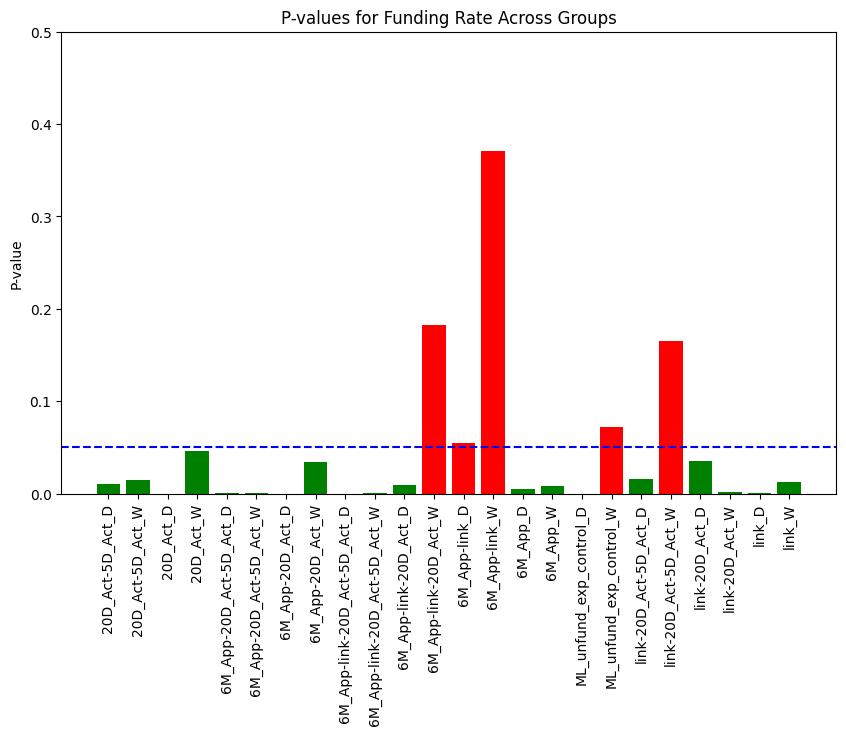

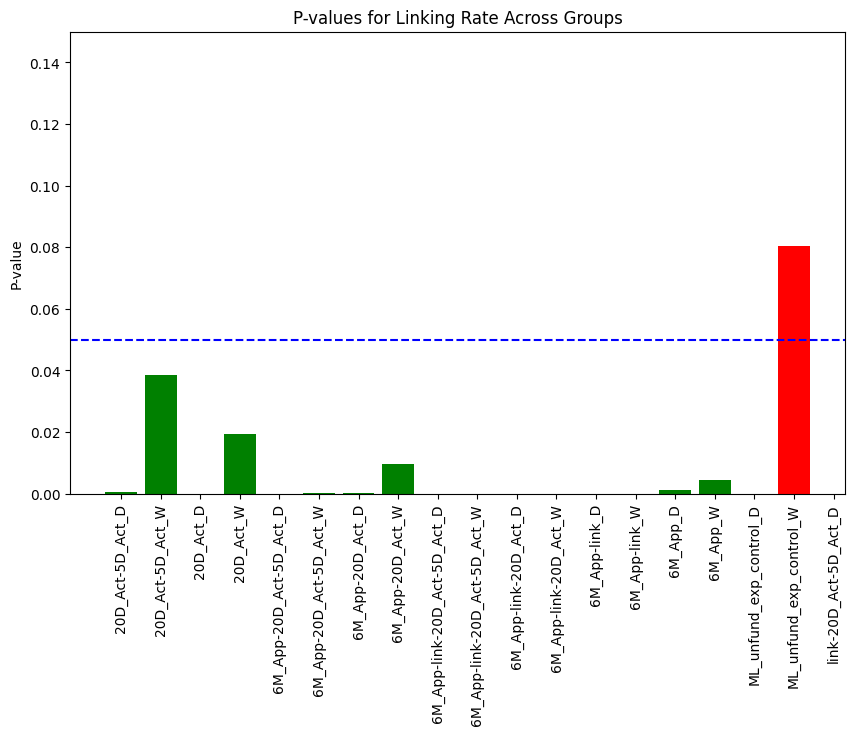

In [90]:
# Plotting

df_p_values['funding_significant'] = df_p_values['funding_p_value'] < 0.05
df_p_values['linking_significant'] = df_p_values['linking_p_value'] < 0.05

plt.figure(figsize=(10, 6))

plt.bar(df_p_values['group_name'], df_p_values['funding_p_value'], color=df_p_values['funding_significant'].map({True: 'g', False: 'r'}))
plt.xticks(rotation=90)
plt.ylim(0, 0.5)  
plt.axhline(y=0.05, color='b', linestyle='--')  
plt.title('P-values for Funding Rate Across Groups')
plt.ylabel('P-value')
plt.show()

plt.figure(figsize=(10, 6))

plt.bar(df_p_values['group_name'], df_p_values['linking_p_value'], color=df_p_values['linking_significant'].map({True: 'g', False: 'r'}))
plt.xticks(rotation=90)
plt.ylim(0, 0.15)
plt.axhline(y=0.05, color='b', linestyle='--')
plt.title('P-values for Linking Rate Across Groups')
plt.ylabel('P-value')
plt.show()

Green bars will represent groups where the change is statistically significant (p-value < 0.05), and red bars where the change is not statistically significant (p-value >= 0.05).

# 4. Time-series analysis

In [91]:
email_date_df = user_event_df[['user_uuid','group_name']+PO_number_list]
email_date_df.head()

,user_uuid,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,open,open,delivered,delivered,delivered,delivered,open
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
PO_number_dict = {}
for d in range(len(PO_number_list)):
    PO_number_dict[d] = PO_number_list[d]
PO_number_dict

{0: 'ml_funding_enables_investing',
 1: 'ml_investing_starts_here',
 2: 'ml_explore_the_app_investing',
 3: 'ml_funding_faq',
 4: 'ml_user_clustering_emails_fracs',
 5: 'ml_funding_is_safe',
 6: 'ml_picking_an_investment',
 7: 'ml_investing_101',
 8: 'ml_diversified_portfolio',
 9: 'ml_explore_the_app_list'}

In [94]:
email_event_name_df = sample_exp_df.copy()
for d in range(len(PO_number_list)):
    email_event_name_df['order_'+str(d)] = email_event_name_df['order_'+str(d)].map(PO_number_dict)

email_event_name_df.head()

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,0,ML_unfund_exp_control_D,ml_funding_is_safe,ml_investing_101,ml_funding_faq,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_explore_the_app_list,ml_funding_enables_investing,ml_investing_starts_here,ml_picking_an_investment,ml_explore_the_app_investing
1,id_14752263936159847779,0,ML_unfund_exp_control_D,ml_funding_faq,ml_investing_starts_here,ml_picking_an_investment,ml_funding_enables_investing,ml_funding_is_safe,ml_explore_the_app_list,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_investing_101,ml_explore_the_app_investing
2,id_3723259155072282145,0,ML_unfund_exp_control_D,ml_diversified_portfolio,ml_investing_101,ml_funding_faq,ml_picking_an_investment,ml_investing_starts_here,ml_user_clustering_emails_fracs,ml_explore_the_app_investing,ml_explore_the_app_list,ml_funding_enables_investing,ml_funding_is_safe
3,id_9433964625840258739,0,ML_unfund_exp_control_D,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_picking_an_investment,ml_funding_is_safe,ml_investing_101,ml_user_clustering_emails_fracs,ml_explore_the_app_list,ml_funding_faq,ml_explore_the_app_investing
4,id_17251718038176858460,0,ML_unfund_exp_control_D,ml_picking_an_investment,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_investing_101,ml_funding_faq,ml_funding_is_safe,ml_explore_the_app_investing,ml_explore_the_app_list,ml_user_clustering_emails_fracs


In [101]:
big_table_df = email_event_name_df.merge(email_date_df.drop(columns = ['group_name']),on='user_uuid', how = 'left')
big_table_df.head()

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,id_2623238174270264636,0,ML_unfund_exp_control_D,ml_funding_is_safe,ml_investing_101,ml_funding_faq,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_explore_the_app_list,ml_funding_enables_investing,ml_investing_starts_here,ml_picking_an_investment,ml_explore_the_app_investing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id_14752263936159847779,0,ML_unfund_exp_control_D,ml_funding_faq,ml_investing_starts_here,ml_picking_an_investment,ml_funding_enables_investing,ml_funding_is_safe,ml_explore_the_app_list,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_investing_101,ml_explore_the_app_investing,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered
2,id_3723259155072282145,0,ML_unfund_exp_control_D,ml_diversified_portfolio,ml_investing_101,ml_funding_faq,ml_picking_an_investment,ml_investing_starts_here,ml_user_clustering_emails_fracs,ml_explore_the_app_investing,ml_explore_the_app_list,ml_funding_enables_investing,ml_funding_is_safe,delivered,delivered,open,open,open,delivered,delivered,delivered,delivered,open
3,id_9433964625840258739,0,ML_unfund_exp_control_D,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_picking_an_investment,ml_funding_is_safe,ml_investing_101,ml_user_clustering_emails_fracs,ml_explore_the_app_list,ml_funding_faq,ml_explore_the_app_investing,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
4,id_17251718038176858460,0,ML_unfund_exp_control_D,ml_picking_an_investment,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_investing_101,ml_funding_faq,ml_funding_is_safe,ml_explore_the_app_investing,ml_explore_the_app_list,ml_user_clustering_emails_fracs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


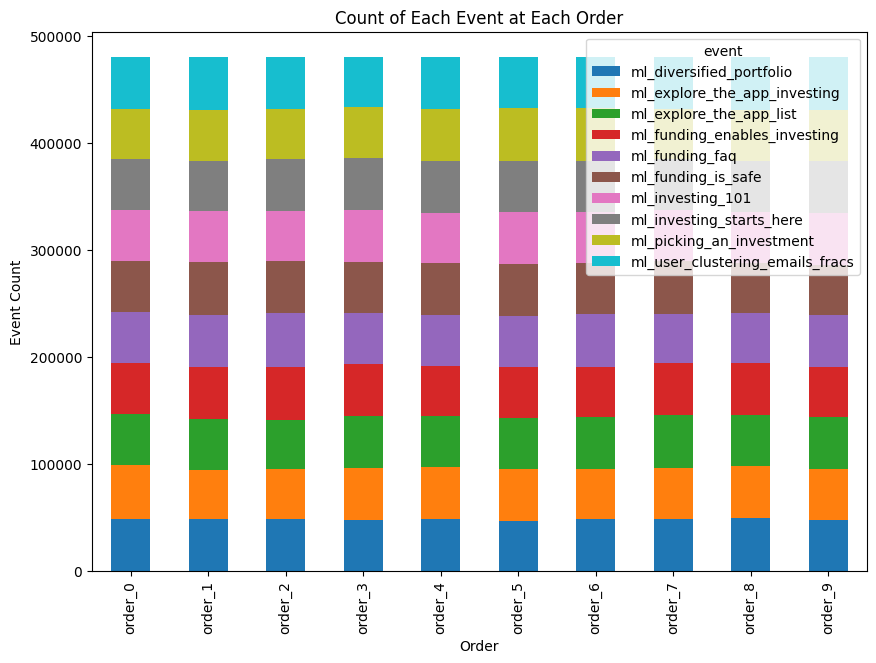

In [103]:
# Step 1: Melt the dataframe to make it long-format
melted_df = big_table_df.melt(id_vars=['user_uuid', 'group_id', 'group_name'], 
                              value_vars=[f'order_{i}' for i in range(10)], 
                              var_name='order', 
                              value_name='event')

# Step 2: Count occurrences of each event at each order
event_counts = melted_df.groupby(['order', 'event']).size().unstack().fillna(0)

# Step 3: Plot the event counts
event_counts.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.xlabel('Order')
plt.ylabel('Event Count')
plt.title('Count of Each Event at Each Order')
plt.show()

# 6. Conclusion and evaluation 